# Integrating a User-provided simulator in the end-to-end AutoEmulate workflow 

### In this workflow we demonstrate the integration of a Cardiovascular simulator, Naghavi Model from ModularCirc in the end-to-end AutoEmulate workflow. 
Naghavi model is a 0D (zero-dimensional) computational model of the cardiovascular system, which is used to simulate blood flow and pressure dynamics in the heart and blood vessels.

This demo includes:
- Setting up parameter ranges 
- Creating sapmles
- Running the simulator to generate training data for the emulator 
- Using Autoemulate to find the best pre-processing technique and model tailored to the simulation data 
- Applying history matching to refine the model and enhance parameter ranges 
- Sensitvity Analysis 


<img src="../../misc/workflow.png" alt="Work Flow" style="width:100%;"/>


## Additional dependency requirements

#### In this demonstration we are using the Naghavi Model Simulator from ModularCirc library. Therefore, the user needs to install the ModularCirc library in their existing AutoEmulate virtual environemnt as an additional dependency. 

In [1]:
# ! pip install git+https://github.com/alan-turing-institute/ModularCirc.git@dev

#### 1 - Create a dictionary called `parameters_range` which contains the name of the simulator input parameters and their range.

In [2]:
from autoemulate.simulations.naghavi_cardiac_ModularCirc import extract_parameter_ranges
# Usage example:
parameters_range = extract_parameter_ranges('/Users/mfamili/work/ModularCirc/Tutorials/Tutorial_03/Parameters_01.json')
parameters_range

{'ao.r': (120.0, 360.0),
 'ao.c': (0.15, 0.44999999999999996),
 'art.r': (562.5, 1687.5),
 'art.c': (1.5, 4.5),
 'ven.r': (4.5, 13.5),
 'ven.c': (66.65, 199.95000000000002),
 'av.r': (3.0, 9.0),
 'mv.r': (2.05, 6.1499999999999995),
 'la.E_pas': (0.22, 0.66),
 'la.E_act': (0.225, 0.675),
 'la.v_ref': (5.0, 15.0),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.5, 1.5),
 'lv.E_act': (1.5, 4.5),
 'lv.v_ref': (5.0, 15.0),
 'lv.k_pas': (0.00999, 0.045)}

#### 2 - Use  `LatinHypercube` method from AutoEmulate to generate initial samples using the parameters range 

In [3]:
import pandas as pd
import numpy as np
from autoemulate.experimental_design import LatinHypercube

# Generate Latin Hypercube samples
N_samples = 150
lhd = LatinHypercube(list(parameters_range.values()))
sample_array = lhd.sample(N_samples)
sample_df = pd.DataFrame(sample_array, columns=parameters_range.keys())

print("Number of parameters:", sample_df.shape[1], "Number of samples from each parameter:", sample_df.shape[0])
sample_df.head()

Number of parameters: 16 Number of samples from each parameter: 150


,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas
0,220.417580,0.158855,711.806500,2.463597,6.441711,97.400951,4.472297,5.489104,0.385284,0.628555,9.255288,0.018202,1.103119,2.105709,9.128405,0.022343
1,241.573796,0.344417,877.928918,4.012018,7.281243,138.490361,7.118652,5.831956,0.597216,0.531402,5.013601,0.062020,1.448820,2.770146,5.119681,0.014466
2,268.542057,0.324294,1245.464736,2.330277,5.994362,71.966297,8.553109,4.199312,0.387561,0.310674,7.639806,0.042611,1.060139,4.098399,12.458935,0.034230
3,316.182077,0.334720,1456.801112,3.921741,11.705805,188.350811,7.408038,2.516133,0.464282,0.659185,5.749487,0.055334,0.821214,2.152684,7.075700,0.014791
4,249.287356,0.358527,873.782564,2.726037,13.189173,76.710130,4.888353,4.914909,0.227167,0.249329,5.180131,0.027008,0.881797,2.577496,12.763565,0.013152


#### 3 - Wrapping your Simulator in AutoEmulate Simulator Base Class

<img src="../../misc/base_simulator_guid.png" alt="Work Flow" style="width:50%;"/>


In [4]:
from autoemulate.simulations.naghavi_cardiac_ModularCirc import NaghaviSimulator
# Initialize simulator with specific outputs
simulator = NaghaviSimulator(
    parameters_range=parameters_range, 
    output_variables=['lv.P_i', 'lv.P_o'],  # Only the ones you're interested in
    n_cycles=300, 
    dt=0.001,
)

#### 4 - run the simulator using the `run_batch_simulations` for all your samples to obtain trainign data for training your emulator 

In [5]:
# Run batch simulations with the samples generated in Cell 1
results = simulator.run_batch_simulations(sample_df)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

Running simulations:   0%|          | 0/150 [00:00<?, ?sample/s]

Successfully completed 150/150 simulations (100.0%)


#### Note that the first two steps can be 

In [6]:
print("Output names:", simulator.output_names)
results_df

Output names: ['lv.P_i_min', 'lv.P_i_max', 'lv.P_i_mean', 'lv.P_i_range', 'lv.P_o_min', 'lv.P_o_max', 'lv.P_o_mean', 'lv.P_o_range']


,0,1,2,3,4,5,6,7
0,8.084556,17.067123,15.730090,8.982567,8.084556,17.067123,15.730090,8.982567
1,4.608005,11.388487,9.742470,6.780483,4.608005,11.388487,9.742470,6.780483
2,23.273084,24.485836,23.881522,1.212752,23.273084,24.485836,23.881522,1.212752
3,2.622856,9.784748,8.360487,7.161891,2.622856,9.784748,8.360487,7.161891
4,2.045767,8.294563,5.496532,6.248796,2.045767,8.294563,5.496532,6.248796
...,...,...,...,...,...,...,...,...
145,2.686755,6.257442,5.000957,3.570687,2.686755,6.257442,5.000957,3.570687
146,1.740035,6.183713,4.186769,4.443678,1.740035,6.183713,4.186769,4.443678
147,20.017860,25.072753,24.406799,5.054894,20.017860,25.072753,24.406799,5.054894
148,35.240985,36.780867,36.007860,1.539882,35.240985,36.780867,36.007860,1.539882


test your simulator with our test function to make sure it ios compatible wih AutoEmulate pipelien 

In [7]:
# need a test for the simulator 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import autoemulate as ae
from tqdm import tqdm
import os

from autoemulate.experimental_design import LatinHypercube
from autoemulate.compare import AutoEmulate
from autoemulate.plotting import _predict_with_optional_std


preprocessing_methods = [{"name" : "PCA", "params" : {"reduced_dim": 2}}]
em = AutoEmulate()
em.setup(sample_df, results, models=["gp"], scale_output = True, reduce_dim_output=True, preprocessing_methods=preprocessing_methods)


,Values
Simulation input shape (X),"(150, 16)"
Simulation output shape (y),"(150, 8)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Scale output data (scale_output),True
Scaler output (scaler_output),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),True


In [9]:
best_model = em.compare()

Cross-validating:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,PCA,GaussianProcess,gp,2,1.494105,0.958277
1,PCA,GaussianProcess,gp,0,1.498750,0.950117
2,PCA,GaussianProcess,gp,3,2.598156,0.928079
3,PCA,GaussianProcess,gp,4,1.959770,0.905604
4,PCA,GaussianProcess,gp,1,2.223571,0.905267


In [11]:
#em.plot_eval(model=best_model)
best_model

InputOutputPipeline(regressor=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model', GaussianProcess())]),
                    transformer=Pipeline(steps=[('scaler_output',
                                                 StandardScaler()),
                                                ('dim_reducer_output',
                                                 PCA(n_components=2))]))

In [12]:
## 3) Evaluate the emulator (on the test set)
gp = em.get_model('GaussianProcess')
em.evaluate(gp)

,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,PCA,3.41,0.8825


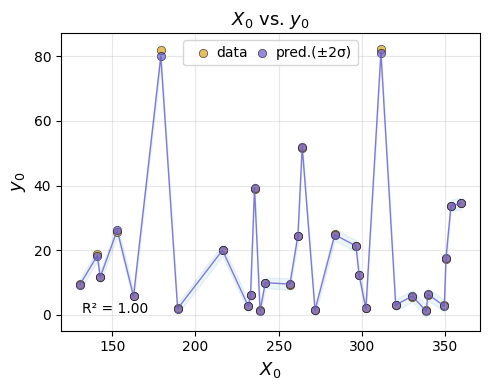

In [13]:
gp
gp_final = em.refit(gp)
em.plot_eval(gp_final)

now run hjistory matching

In [15]:
from autoemulate.history_matching import HistoryMatcher
# Define observed data with means and variances
observations = {
    'lv.P_i_min': (0.0, 0.1),   # Minimum of minimum LV pressure
    'lv.P_i_max': (20.0, 0.1),   # Maximum of minimum LV pressure
    'lv.P_i_mean': (15.0, 0.1),  # Mean of minimum LV pressure
    'lv.P_i_range': (15.0, 0.5), # Range of minimum LV pressure
    'lv.P_o_min': (1.0, 0.1),  # Minimum of maximum LV pressure
    'lv.P_o_max': (13.0, 0.1),  # Maximum of maximum LV pressure
    'lv.P_o_mean': (12.0, 0.1), # Mean of maximum LV pressure
    'lv.P_o_range': (20.0, 0.5)  # Range of maximum LV pressure
}
    
# Test generating samples
samples = simulator.sample_inputs(10)

# Create history matcher
hm = HistoryMatcher(
    simulator=simulator,
    observations=observations,  # This needs both means and variances
    threshold=3.0
)

# Run history matching
all_samples, all_impl_scores, emulator = hm.run_history_matching(
    n_waves=20,
    n_samples_per_wave=10,
    use_emulator=True,
    initial_emulator=gp_final,
)

History Matching: 100%|██████████| 20/20 [00:00<00:00, 39.18wave/s, max_impl=27.50, min_impl=0.25, nroy=0, samples=10]                                                          


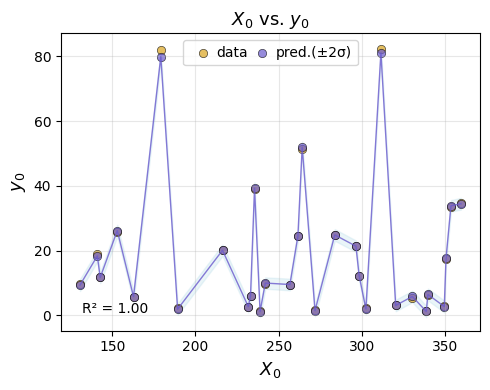

In [16]:
em.plot_eval(emulator)

In [17]:
em.evaluate(emulator)

,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,PCA,0.4199,0.9994


In [18]:
from autoemulate.history_matching_dashboard import HistoryMatchingDashboard
dashboard = HistoryMatchingDashboard(
    samples=all_samples,
    impl_scores=all_impl_scores,
    param_names=simulator.param_names,  # Use simulator.param_names instead of parameter_names
    output_names=simulator.output_names  # Use simulator.output_names instead of output_names
)
dashboard.display()

In [19]:
# Extract parameter names and bounds from the dictionary
parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds
}


In [20]:
em.sensitivity_analysis(problem=problem)


,output,parameter,index,value,confidence
0,y1,ao.r,S1,0.000198,0.000037
1,y1,ao.c,S1,0.000138,0.000024
2,y1,art.r,S1,0.000076,0.000011
3,y1,art.c,S1,0.000137,0.000027
4,y1,ven.r,S1,0.000109,0.000016
...,...,...,...,...,...
115,y8,"(lv.E_pas, lv.v_ref)",S2,0.022853,0.038434
116,y8,"(lv.E_pas, lv.k_pas)",S2,0.106229,0.045298
117,y8,"(lv.E_act, lv.v_ref)",S2,0.011315,0.021376
118,y8,"(lv.E_act, lv.k_pas)",S2,0.010687,0.025729
